# Spotify Analysis

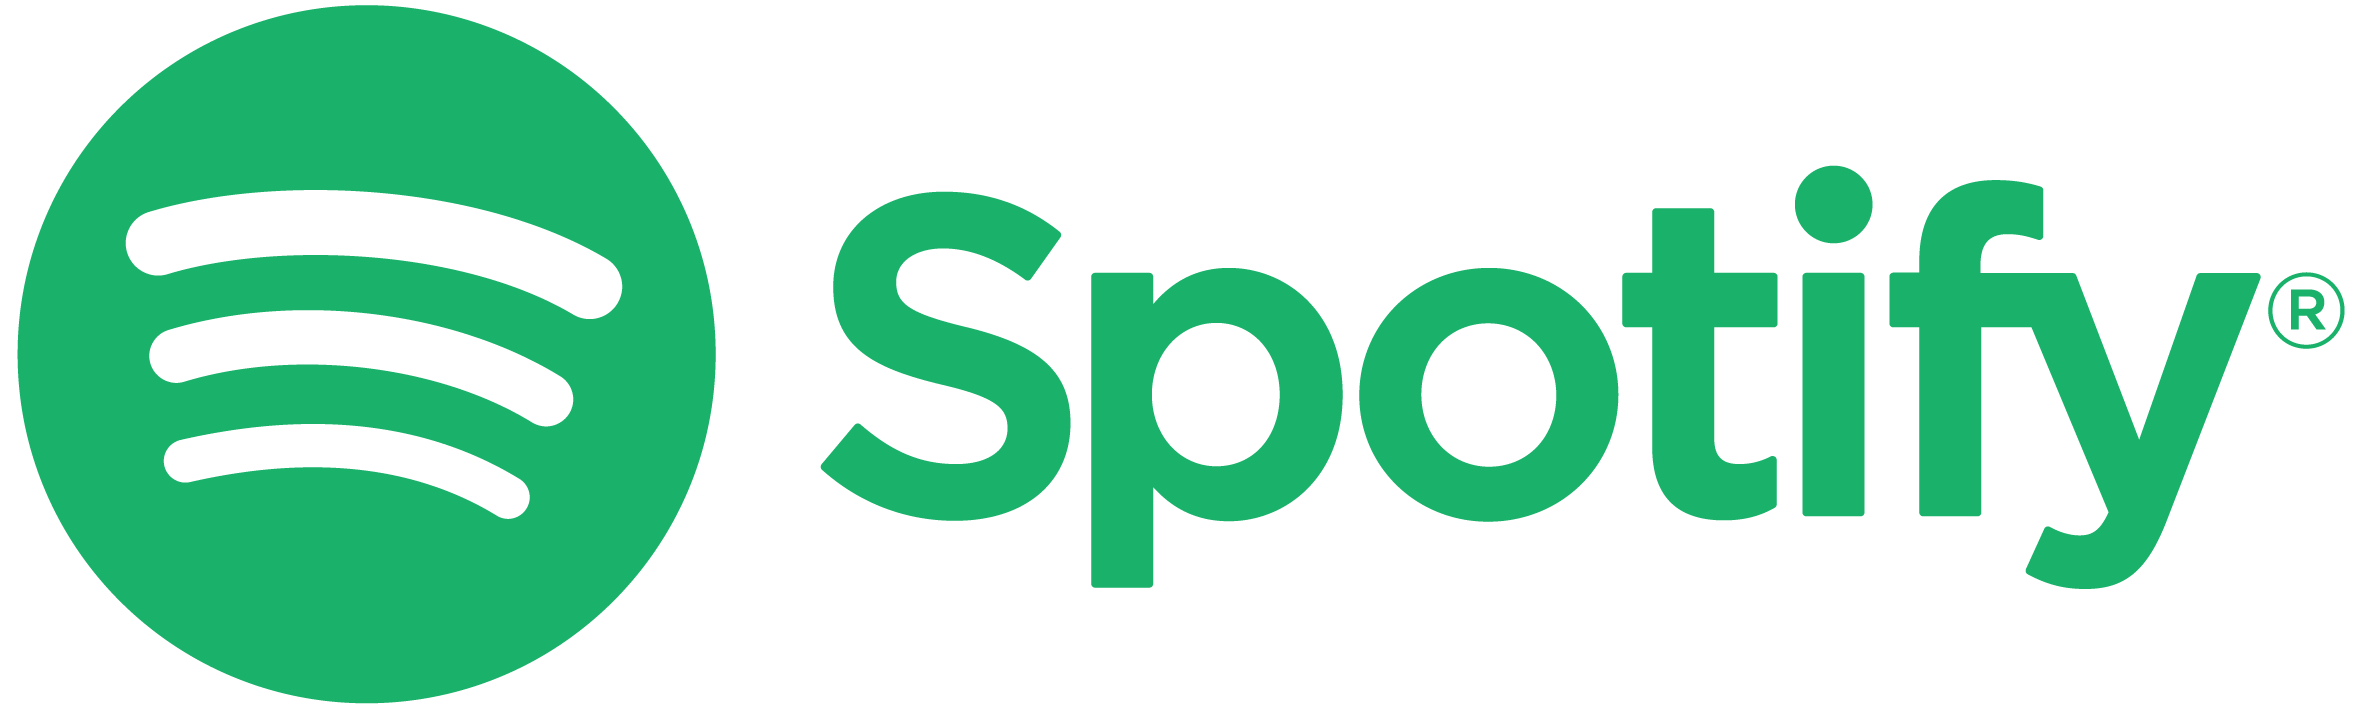

### by: Luke Weiss

In [1]:
import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearn.linear_model import LinearRegression,  LogisticRegression
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import zipfile

import warnings
warnings.filterwarnings('ignore')

import copy

## Preprocessing of data:

In [2]:
top100_2000 = pd.read_csv("spotify.csv", delimiter = ";")
zf2 = zipfile.ZipFile("spotify_data.csv.zip")
df2 = pd.read_csv(zf2.open('data.csv'))

In [3]:
df2.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [4]:
top100_2000.head()

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96


In [5]:
print(top100_2000.shape)
print(df2.shape)

(2385, 14)
(170653, 19)


In [6]:
# I want to add total artist streams as a column to take into account. This is because more popular artists are going to be more likely to have more popular songs.
#First I am going to parse the first artists name from each row in the df.
artist_list = list()
for artist in df2["artists"]:
    current_artist = artist
    for ch in ["[", "]", "'"]:
        current_artist = current_artist.replace(ch, "")
        
    current_artist = current_artist.split(",")
    artist_list.append(current_artist[0])
    
df2["Top Artist"] = artist_list

In [7]:
# Then I am going to get a dict matching each artist name to the total number of streams they have by extracting it from a csv file I got on kaggle
# source: https://www.kaggle.com/datasets/adnananam/spotify-artist-stats

artist_data = pd.read_csv("spotify_artist_data.csv")
artist_data = artist_data[["Artist Name", "Lead Streams"]]
artist_streams = artist_data.set_index('Artist Name').to_dict()['Lead Streams']
artist_streams.pop("Artist")
for artist in artist_streams:
    curr_streams = artist_streams[artist]
    artist_streams[artist] = int(curr_streams.replace(",", ""))
    
artist_streams["Drake"]

50162292808

In [8]:
# Now, for each row in the df I am checking if the artist has a corresponding key in the dict above, if it does I am adding streams to that row, if not I am adding
# 0 to that row
streams_list = []
for artist in df2["Top Artist"]:
    if artist in artist_streams:
        streams_list.append(artist_streams[artist])
    else:
        streams_list.append(0)

df2["Streams"] = streams_list
df2.head()

streams_list2 = []
for artist in top100_2000["artist"]:
    if artist in artist_streams:
        streams_list2.append(artist_streams[artist])
    else:
        streams_list2.append(0)

top100_2000["Streams"] = streams_list2

In [9]:
top100_2000.rename(columns = {"danceability ": "danceability", "speechiness ": "speechiness"}, 
          inplace = True)
top100_2000_updated = top100_2000[["bpm", "energy", "dB", "liveness", "duration", "acousticness", "danceability", "speechiness", "popularity", "Streams"]]
top100_2000_updated

,bpm,energy,dB,liveness,duration,acousticness,danceability,speechiness,popularity,Streams
0,118,68,-4,3,200,6,71,7,98,9940559934
1,120,59,-8,35,174,44,78,3,97,0
2,95,64,-7,17,195,74,77,14,96,3871106303
3,133,81,-8,25,131,25,70,5,96,0
4,98,62,-6,8,222,42,72,5,96,7262115562
...,...,...,...,...,...,...,...,...,...,...
2380,140,88,-6,10,228,19,60,4,21,0
2381,150,90,-4,36,241,0,55,9,16,0
2382,100,87,-7,9,255,0,60,5,15,0
2383,120,80,-6,7,179,0,65,6,11,0


In [10]:
# Matching columns and making sure the scales are the same so that I can concat them. 
updated_songs = df2[["tempo", "energy", "loudness", "liveness", "duration_ms", "acousticness", "danceability", "speechiness", "popularity", "Streams"]]
updated_songs["energy"] = updated_songs["energy"].apply(lambda x: x*1e2)
updated_songs.columns = ["bpm", "energy", "dB", "liveness", "duration", "acousticness", "danceability", "speechiness", "popularity", "Streams"]
updated_songs["liveness"] = updated_songs["liveness"].apply(lambda x: x*1e2)
updated_songs["duration"] = updated_songs["duration"].apply(lambda x: x / 1e3)
updated_songs["acousticness"] = updated_songs["acousticness"].apply(lambda x: x*1e2)
updated_songs["danceability"] = updated_songs["danceability"].apply(lambda x: x*1e2)
updated_songs["speechiness"] = updated_songs["speechiness"].apply(lambda x: x*1e2)


updated_songs = updated_songs.reset_index()
updated_songs = updated_songs.drop(["index"], axis = 1)
updated_songs.head()

,bpm,energy,dB,liveness,duration,acousticness,danceability,speechiness,popularity,Streams
0,80.954,21.1,-20.096,66.5,831.667,98.2,27.9,3.66,4,0
1,60.936,34.1,-12.441,16.0,180.533,73.2,81.9,41.50,5,0
2,110.339,16.6,-14.850,10.1,500.062,96.1,32.8,3.39,5,0
3,100.109,30.9,-9.316,38.1,210.000,96.7,27.5,3.54,3,0
4,101.665,19.3,-10.096,22.9,166.693,95.7,41.8,3.80,2,0


In [11]:
master_df = pd.concat([updated_songs, top100_2000_updated])
master_df

,bpm,energy,dB,liveness,duration,acousticness,danceability,speechiness,popularity,Streams
0,80.954,21.1,-20.096,66.5,831.667,98.2,27.9,3.66,4,0
1,60.936,34.1,-12.441,16.0,180.533,73.2,81.9,41.50,5,0
2,110.339,16.6,-14.850,10.1,500.062,96.1,32.8,3.39,5,0
3,100.109,30.9,-9.316,38.1,210.000,96.7,27.5,3.54,3,0
4,101.665,19.3,-10.096,22.9,166.693,95.7,41.8,3.80,2,0
...,...,...,...,...,...,...,...,...,...,...
2380,140.000,88.0,-6.000,10.0,228.000,19.0,60.0,4.00,21,0
2381,150.000,90.0,-4.000,36.0,241.000,0.0,55.0,9.00,16,0
2382,100.000,87.0,-7.000,9.0,255.000,0.0,60.0,5.00,15,0
2383,120.000,80.0,-6.000,7.0,179.000,0.0,65.0,6.00,11,0


In [12]:
# Everything scaled in df

master_scaled = copy.copy(master_df)
scaler = StandardScaler()
 
master_scaled = scaler.fit_transform(master_scaled.to_numpy())
master_scaled = pd.DataFrame(master_scaled, columns=[
  "bpm", "energy", "dB", "liveness", "duration", "acousticness", "danceability", "speechiness", "popularity", "Streams"])

master_scaled

,bpm,energy,dB,liveness,duration,acousticness,danceability,speechiness,popularity,Streams
0,-1.172256,-1.025058,-1.526776,2.635600,4.792882,1.287754,-1.475706,-0.381671,-1.260496,-0.332647
1,-1.825041,-0.539354,-0.184395,-0.260684,-0.401646,0.623490,1.586536,1.954125,-1.215431,-0.332647
2,-0.214014,-1.193187,-0.606838,-0.599061,2.147449,1.231956,-1.197836,-0.398338,-1.215431,-0.332647
3,-0.547614,-0.658912,0.363604,1.006799,-0.166569,1.247898,-1.498389,-0.389079,-1.305561,-0.332647
4,-0.496873,-1.092310,0.226824,0.135046,-0.512057,1.221328,-0.687462,-0.373029,-1.350626,-0.332647
...,...,...,...,...,...,...,...,...,...,...
173033,0.753228,1.474450,0.945098,-0.604797,-0.022971,-0.816637,0.344627,-0.360684,-0.494392,-0.332647
173034,1.079327,1.549174,1.295818,0.886359,0.080739,-1.321478,0.061086,-0.052042,-0.719716,-0.332647
173035,-0.551168,1.437088,0.769738,-0.662149,0.192426,-1.321478,0.344627,-0.298955,-0.764781,-0.332647
173036,0.101030,1.175555,0.945098,-0.776853,-0.413876,-1.321478,0.628168,-0.237227,-0.945041,-0.332647


In [13]:
# Everything scaled in df except popularity column
master_scaled2 = copy.copy(master_df)


cols = master_scaled2.columns[master_scaled2.columns != 'popularity']
master_scaled2[cols] = scaler.fit_transform(master_scaled2[cols])
master_scaled2

,bpm,energy,dB,liveness,duration,acousticness,danceability,speechiness,popularity,Streams
0,-1.172256,-1.025058,-1.526776,2.635600,4.792882,1.287754,-1.475706,-0.381671,4,-0.332647
1,-1.825041,-0.539354,-0.184395,-0.260684,-0.401646,0.623490,1.586536,1.954125,5,-0.332647
2,-0.214014,-1.193187,-0.606838,-0.599061,2.147449,1.231956,-1.197836,-0.398338,5,-0.332647
3,-0.547614,-0.658912,0.363604,1.006799,-0.166569,1.247898,-1.498389,-0.389079,3,-0.332647
4,-0.496873,-1.092310,0.226824,0.135046,-0.512057,1.221328,-0.687462,-0.373029,2,-0.332647
...,...,...,...,...,...,...,...,...,...,...
2380,0.753228,1.474450,0.945098,-0.604797,-0.022971,-0.816637,0.344627,-0.360684,21,-0.332647
2381,1.079327,1.549174,1.295818,0.886359,0.080739,-1.321478,0.061086,-0.052042,16,-0.332647
2382,-0.551168,1.437088,0.769738,-0.662149,0.192426,-1.321478,0.344627,-0.298955,15,-0.332647
2383,0.101030,1.175555,0.945098,-0.776853,-0.413876,-1.321478,0.628168,-0.237227,11,-0.332647


## Basic Data Exploration

In [14]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173038 entries, 0 to 2384
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   bpm           173038 non-null  float64
 1   energy        173038 non-null  float64
 2   dB            173038 non-null  float64
 3   liveness      173038 non-null  float64
 4   duration      173038 non-null  float64
 5   acousticness  173038 non-null  float64
 6   danceability  173038 non-null  float64
 7   speechiness   173038 non-null  float64
 8   popularity    173038 non-null  int64  
 9   Streams       173038 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 14.5 MB


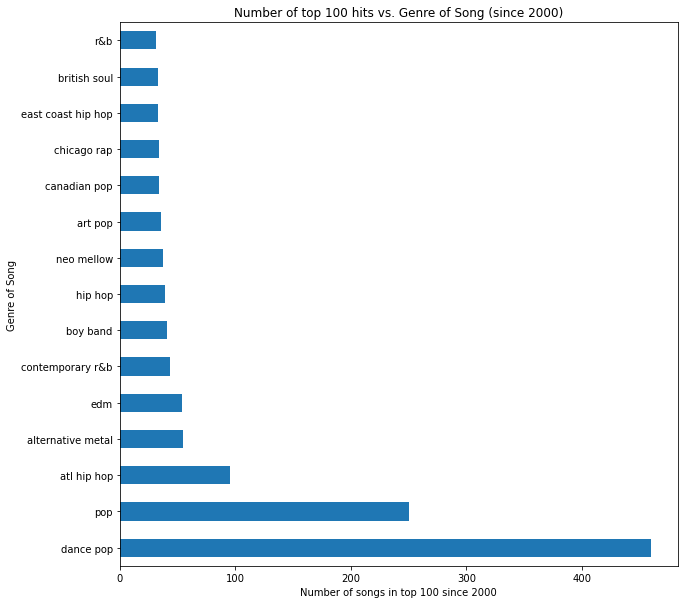

In [15]:
# Most common genres with top hits on spotify
genre_counts = top100_2000["top genre"].value_counts()
ax = genre_counts.head(15).plot.barh(figsize = (10, 10))
ax.set_xlabel("Number of songs in top 100 since 2000")
ax.set_ylabel("Genre of Song")
ax.set_title("Number of top 100 hits vs. Genre of Song (since 2000)")
None

<AxesSubplot:>

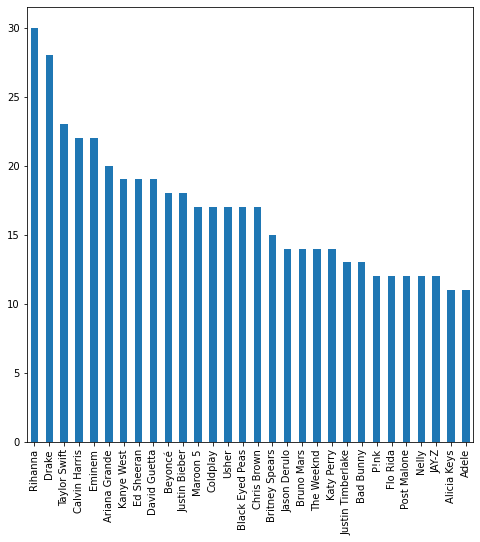

In [16]:
# Artists with more than 10 top 100 hits since 2000
art_top = top100_2000["artist"].value_counts()
art_more_10 = art_top[art_top > 10]
art_more_10.plot.bar(figsize = (8, 8))

In [17]:
# Artists with one hit wonders since 2000
one_wonder = art_top[art_top == 1]
one_wonder_artists = list(one_wonder.index)
one_wonder_artists[:20]

['DaFOO',
 'Papa Roach',
 'Elbow',
 'Bubba Sparxxx',
 'Busted',
 'Khia',
 'Truth Hurts',
 'Judika',
 'E-40',
 'G-Unit',
 'Stormzy',
 'London',
 'Shop Boyz',
 'Stefflon Don',
 'The Supermen Lovers',
 'Simple Plan',
 'BOYS LIKE GIRLS',
 'Big Shaq',
 'LMC',
 'Dom Devino']

In [18]:
# Averages of multiple musical categories
means = master_df[["bpm", "energy", "dB", "liveness", "duration", "acousticness", "danceability", "speechiness", "popularity"]].mean()
means

bpm             116.901865
energy           48.535959
dB              -11.389475
liveness         20.545316
duration        230.879374
acousticness     49.734602
danceability     53.922803
speechiness       9.843090
popularity       31.970642
dtype: float64

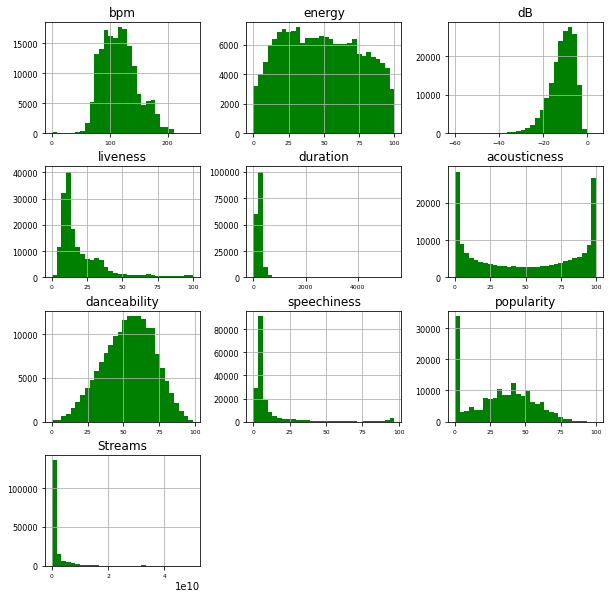

In [19]:
# Looking at the distributions of all the numerical variables
distributions = master_df.select_dtypes(include = ['int64', "float64"])
ax = distributions.hist(figsize=(10, 10), bins=30, xlabelsize=6, ylabelsize=8, color = "green")

In [20]:
# Building a dictionary with each genre having its corresponding data (since 2000 only)
all_genres = list(top100_2000["top genre"].value_counts().index)
genre_dfs = dict()
for genre in all_genres:
    genre_dfs[genre] = top100_2000[top100_2000["top genre"] == genre]

In [21]:
# For example, this is all the dance pop songs (since 2000 only)
genre_dfs["dance pop"]

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity,Streams
59,When I Was Your Man,Bruno Mars,dance pop,2012,73,28,61,-9,9,39,214,93,4,89,18201285113
65,Locked out of Heaven,Bruno Mars,dance pop,2012,144,70,73,-4,31,87,233,5,4,88,18201285113
69,One Kiss (with Dua Lipa),Calvin Harris,dance pop,2018,124,86,79,-3,8,59,215,4,11,88,17820311936
99,Woman,Doja Cat,dance pop,2021,108,76,82,-4,12,88,173,9,9,87,11973361879
136,That's What I Like,Bruno Mars,dance pop,2016,134,56,85,-5,9,86,207,1,4,86,18201285113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,Turnin Me On - Original Dirty,Keri Hilson,dance pop,2008,160,58,66,-5,13,9,248,0,6,43,0
2329,With Every Heartbeat,Robyn,dance pop,2005,121,88,50,-4,23,41,253,1,4,43,0
2332,Loverboy,Mariah Carey,dance pop,2001,103,79,72,-4,10,82,229,18,12,42,5888465193
2354,Bounce With Me (feat. Xscape) - Edited Album V...,Bow Wow,dance pop,2000,72,75,85,-5,27,93,176,43,17,36,0


Text(0.5, 1.0, 'Genres with over 50 songs in the top 100 averages')

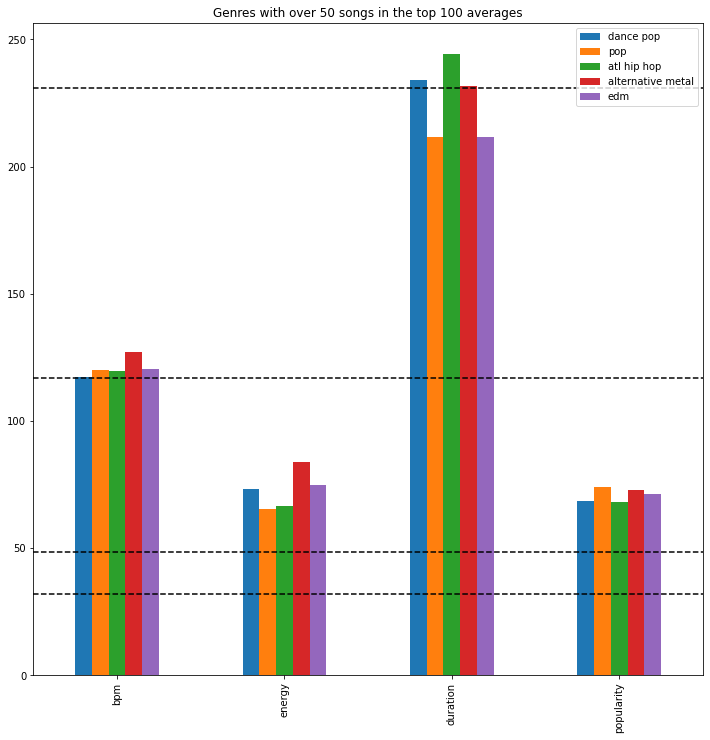

In [22]:
# Trying to see which parts of top 100 songs are above/below average
genre_counts = top100_2000["top genre"].value_counts()
popular_genres = list(genre_counts[genre_counts > 50].index)
genres_stats = dict()
for genre in popular_genres:
    current_df = genre_dfs[genre]
    cur_bpm = round(current_df["bpm"].mean(), 2)
    cur_energy = round(current_df["energy"].mean(), 2)
    cur_duration = round(current_df["duration"].mean(), 2)
    cur_popularity = round(current_df["popularity"].mean(), 2)
    cur_df_list = [cur_bpm, cur_energy, cur_duration, cur_popularity]
    genres_stats[genre] = cur_df_list
genres_stats_df = pd.DataFrame(genres_stats, index = ["bpm", "energy", "duration", "popularity"])

ax = genres_stats_df.plot.bar(figsize = (12, 12))
ax.axhline(y = means["bpm"], linestyle = "--", color = "black")
ax.axhline(y = means["energy"], linestyle = "--", color = "black")
ax.axhline(y = means["duration"], linestyle = "--", color = "black")
ax.axhline(y = means["popularity"], linestyle = "--", color = "black")
ax.set_title("Genres with over 50 songs in the top 100 averages")

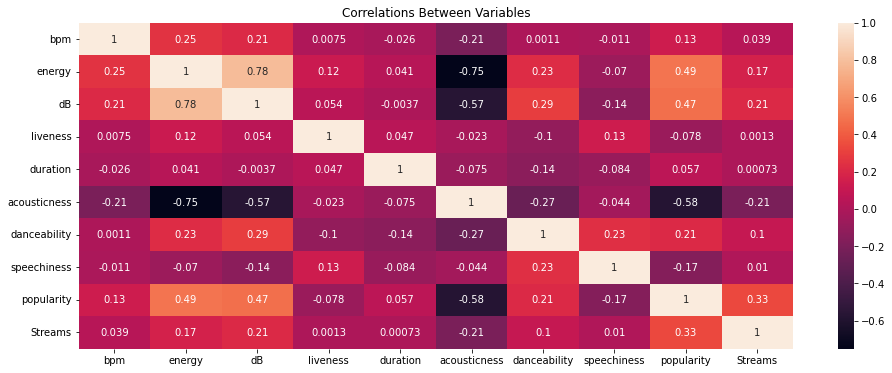

In [23]:
plt.figure(figsize=(16, 6))
plot = sns.heatmap(master_df.corr(), annot = True)
plot.set_title("Correlations Between Variables")
None
# Appears that variables that have strongest correlation with popularity is bpm, energy, dB, acousticness, danceability, speechiness, and streams

## Part 2: Building Models

### Linear Regression

In [24]:
# Basic ML model to predict popularity of a given pop song based on bpm, energy, speechiness, duration
xcols1 = ["bpm", "energy", "dB", "acousticness", "danceability", "speechiness", "Streams"]
ycols1 = "popularity"

pop_df = genre_dfs["pop"]
train, test = train_test_split(master_scaled2)
model1 = LinearRegression()
model1.fit(train[xcols1], train[ycols1])
model1score = model1.score(test[xcols1], test[ycols1])

print(f"Model 1 Score: {model1score}")

Model 1 Score: 0.43563100914731123


In [25]:
model2 = Pipeline([
    ("pf", PolynomialFeatures(degree=3, include_bias=False)),
    ("lr", LinearRegression())
])
model2.fit(train[xcols1], train[ycols1])
m2score = model2.score(test[xcols1], test[ycols1])

print(f"Model 2 Score: {m2score}")

Model 2 Score: 0.5531703947905007


### Logistic Regression

In [26]:
new_spotify = copy.copy(master_scaled2)
new_spotify["logistic_rating"] = new_spotify["popularity"].apply(lambda x : x // 10)
new_spotify.head()

,bpm,energy,dB,liveness,duration,acousticness,danceability,speechiness,popularity,Streams,logistic_rating
0,-1.172256,-1.025058,-1.526776,2.635600,4.792882,1.287754,-1.475706,-0.381671,4,-0.332647,0
1,-1.825041,-0.539354,-0.184395,-0.260684,-0.401646,0.623490,1.586536,1.954125,5,-0.332647,0
2,-0.214014,-1.193187,-0.606838,-0.599061,2.147449,1.231956,-1.197836,-0.398338,5,-0.332647,0
3,-0.547614,-0.658912,0.363604,1.006799,-0.166569,1.247898,-1.498389,-0.389079,3,-0.332647,0
4,-0.496873,-1.092310,0.226824,0.135046,-0.512057,1.221328,-0.687462,-0.373029,2,-0.332647,0


In [27]:
# Logistic Regression model to predict how popular a song will be based on bpm, energy, valence, acousticness, liveness, and duration
train, test = train_test_split(new_spotify)
xcols2 = ["bpm", "energy", "dB", "acousticness", "danceability", "speechiness", "Streams"]
ycols2 = "logistic_rating"
model3 = Pipeline([
#     ("std", StandardScaler()),
    ("lr", LogisticRegression(fit_intercept=False, max_iter=100))
])

model3.fit(train[xcols2], train[ycols2])
model3_score = model3.score(test[xcols2], test[ycols2])
model3_cross = cross_val_score(model3, train[xcols2], train[ycols2]).mean()
print(f"10 tiered logistic score: {model3_score}")
print(f"10 tiered logistic cros val: {model3_cross}")

10 tiered logistic score: 0.3625751271382339
10 tiered logistic cros val: 0.3684754001399877


In [28]:
# Adding 3 tiered column to use for this logistic regression
spotify_3_tier = copy.copy(master_scaled2)
spotify_3_tier["popularity3tier"] = spotify_3_tier["popularity"].apply(lambda x: x // 33)
spotify_3_tier.head()

,bpm,energy,dB,liveness,duration,acousticness,danceability,speechiness,popularity,Streams,popularity3tier
0,-1.172256,-1.025058,-1.526776,2.635600,4.792882,1.287754,-1.475706,-0.381671,4,-0.332647,0
1,-1.825041,-0.539354,-0.184395,-0.260684,-0.401646,0.623490,1.586536,1.954125,5,-0.332647,0
2,-0.214014,-1.193187,-0.606838,-0.599061,2.147449,1.231956,-1.197836,-0.398338,5,-0.332647,0
3,-0.547614,-0.658912,0.363604,1.006799,-0.166569,1.247898,-1.498389,-0.389079,3,-0.332647,0
4,-0.496873,-1.092310,0.226824,0.135046,-0.512057,1.221328,-0.687462,-0.373029,2,-0.332647,0


In [29]:
# Logistic regression model attempting to predict 3 tier popularity
train, test = train_test_split(spotify_3_tier)
xcols_3tier = ["bpm", "energy", "dB", "liveness", "duration", "acousticness", "Streams", "danceability"]
ycol_3tier = "popularity3tier"

model3tier = LogisticRegression(fit_intercept=False, max_iter=100)

model3tier.fit(train[xcols_3tier], train[ycol_3tier])
score = model3tier.score(test[xcols_3tier], test[ycol_3tier])
cval = cross_val_score(model3tier, test[xcols_3tier], test[ycol_3tier]).mean()
print(f"3 tier Logistic Score Compared to Real Numbers: {score}")
print(f"3 tier Logistic CV Score: {cval}")
None


# 68% accuracy on categorizing songs into 3 categories of poularity, that is pretty good. 

3 tier Logistic Score Compared to Real Numbers: 0.6773000462320851
3 tier Logistic CV Score: 0.6788719371243642


In [30]:
# 2 tiered regression
copy_2_tier = copy.copy(master_scaled2)
copy_2_tier["tier2"] = copy_2_tier["popularity"].apply(lambda x : x // 50)

train, test = train_test_split(copy_2_tier)
model_2_tier = LogisticRegression(fit_intercept=False, max_iter=100)

x_predictors = ["bpm", "energy", "dB", "liveness", "duration", "acousticness", "Streams", "danceability"]
y_predictor = "tier2"

model_2_tier.fit(train[x_predictors], train[y_predictor])
model_2_tier_score = model_2_tier.score(test[x_predictors], test[y_predictor])
model_2_tier_CV = cross_val_score(model_2_tier, test[x_predictors], test[y_predictor]).mean()
print(f"model_2tier_score : {model_2_tier_score}")
print(f"model_2tier_CV : {model_2_tier_CV}")

# Almsot 75% accuracy on predicting if a song will be poular or not, pretty good. 

model_2tier_score : 0.7438280166435506
model_2tier_CV : 0.7268839574664817


## Decision Trees

In [31]:
# Decision Tree predicting popularity straight up
y = master_scaled2.popularity
features = ["bpm", "energy", "dB", "liveness", "duration", "acousticness", "Streams"]
X = master_scaled2[features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
spotify_tree_model = DecisionTreeRegressor(random_state=1)
spotify_tree_model.fit(train_X, train_y)
val_predictions = spotify_tree_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("MAE:", val_mae)
# Looks like this model is off by almost 15 on average for popularity of the song. 

MAE: 14.619693987627413


In [32]:
# Decision tree classification trying to classify into either 0, 1, or 2
y = spotify_3_tier.popularity3tier
features = ["bpm", "energy", "dB", "liveness", "speechiness", "danceability", "Streams"]
X = spotify_3_tier[features]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tiered = DecisionTreeClassifier(criterion="entropy", max_depth=3)
tiered.fit(train_X, train_y)
val_predictions = tiered.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print(f"MAE: {val_mae}")
accuracy = accuracy_score(val_predictions, val_y)
print(f"ACCURACY: {accuracy}")

MAE: 0.342417938049006
ACCURACY: 0.6634073046694406


In [33]:
# Making data all scaled on a 10 scale for simplicity to the model (besides popularity, keeping that 3 tiered)
master_df_scaled10 = copy.copy(master_df)
for val in ["bpm", "energy", "dB", "liveness", "duration", "acousticness", "danceability", "speechiness", "Streams"]:
    master_df_scaled10[val] = master_df_scaled10[val].apply(lambda x: x // 10)
    
master_df_scaled10["popularity"] = master_df_scaled10["popularity"].apply(lambda x: x // 33)
master_df_scaled10

,bpm,energy,dB,liveness,duration,acousticness,danceability,speechiness,popularity,Streams
0,8.0,2.0,-3.0,6.0,83.0,9.0,2.0,0.0,0,0
1,6.0,3.0,-2.0,1.0,18.0,7.0,8.0,4.0,0,0
2,11.0,1.0,-2.0,1.0,50.0,9.0,3.0,0.0,0,0
3,10.0,3.0,-1.0,3.0,21.0,9.0,2.0,0.0,0,0
4,10.0,1.0,-2.0,2.0,16.0,9.0,4.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
2380,14.0,8.0,-1.0,1.0,22.0,1.0,6.0,0.0,0,0
2381,15.0,9.0,-1.0,3.0,24.0,0.0,5.0,0.0,0,0
2382,10.0,8.0,-1.0,0.0,25.0,0.0,6.0,0.0,0,0
2383,12.0,8.0,-1.0,0.0,17.0,0.0,6.0,0.0,0,0


In [34]:
# This is a decision tree regressor that tries to predict popularity rating 0, 1, or 2. 
y = master_df_scaled10.popularity
features = ["dB", "speechiness",   "acousticness", "Streams"]
X = master_df_scaled10[features]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
spotify_tree_model = DecisionTreeRegressor(random_state=1)
spotify_tree_model.fit(train_X, train_y)
val_predictions = spotify_tree_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)

print("MAE:", val_mae)

MAE: 0.35468840261415885


In [35]:
# Best model so far to predict the 3 tiers of popularity. 
y = master_df_scaled10.popularity
features = ["energy", "duration", "Streams"]
X = master_df_scaled10[features]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tiered = DecisionTreeClassifier()
tiered.fit(train_X, train_y)

val_predictions = tiered.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print(f"MAE: {val_mae}")
accuracy = accuracy_score(val_predictions, val_y)
print(f"ACCURACY: {accuracy}")

MAE: 0.3175913083680074
ACCURACY: 0.6918169209431345


## Clustering 

Text(0, 0.5, 'Inertia')

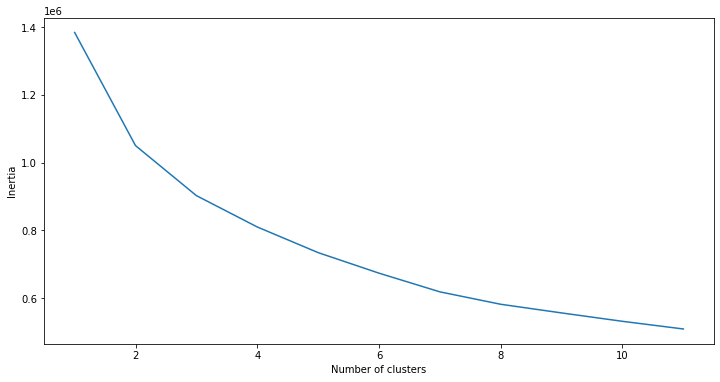

In [36]:
X = master_scaled[["bpm", "energy", "dB", "liveness", "duration", "speechiness", "danceability", "acousticness"]]
sse = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    
cluster_df = pd.DataFrame({'Cluster':range(1,12), 'sse':sse})
cluster_df.head()

plt.figure(figsize=(12,6))
plt.plot(cluster_df['Cluster'], cluster_df['sse'])
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

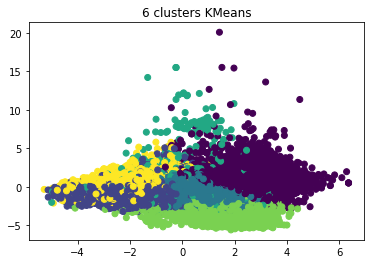

<Figure size 1800x1800 with 0 Axes>

In [37]:
model =  Pipeline([
    ("std", StandardScaler()),
    ("km", KMeans(6)),
])
clusters = model.fit_predict(X)
clusters

PCA_df = copy.copy(master_scaled)

pca = PCA(n_components=2)  
df_2d = pca.fit_transform(master_scaled)
plt.scatter(df_2d[:, 0], df_2d[:, 1], c=clusters)
plt.title("6 clusters KMeans")
plt.figure(figsize = (25, 25))
plt.show()